<a href="https://colab.research.google.com/github/healthonrails/annolid/blob/main/docs/tutorials/Annolid_on_Detectron2_Tutorial.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Annolid on Detectron2 Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to Annolid on detectron2! This is modified from the official colab tutorial of detectron2. Here, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial by "File -> Open in playground mode" and play with it yourself. __DO NOT__ request access to this tutorial.


# Install detectron2

In [1]:
# Is running in colab or in jupyter-notebook
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
# install dependencies: 
!pip install pyyaml==5.3
import torch, torchvision
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

torch:  1.9 ; cuda:  cu102
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random, glob
import matplotlib.pyplot as plt
if IN_COLAB:
  from google.colab.patches import cv2_imshow
else:
  import cv2
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Upload a labeled dataset as follows.
Note: please make sure the is no white space in your file path if you encounter file not found issues.

In [4]:
if IN_COLAB:
    from google.colab import files
else:
    from ipywidgets import FileUpload
    from IPython.display import display
    !jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [5]:
if IN_COLAB:
    uploaded = files.upload()
else:
    uploaded = FileUpload()

In [6]:
display(uploaded)

FileUpload(value={}, description='Upload')

In [7]:
if IN_COLAB:
    dataset =  list(uploaded.keys())[0]
else:
    dataset = list(uploaded.value.keys())[0]

In [8]:
if IN_COLAB:
    !unzip $dataset -d /content/
else:
    #TODO generalize this
    !unzip -o ../../sample_video/$dataset -d .

Archive:  ../../sample_video/sample_video_coco_dataset.zip
  inflating: ./sample_video_coco_dataset/train/JPEGImages/sample_video_00000009_225348.jpg  
  inflating: ./sample_video_coco_dataset/train/JPEGImages/sample_video_00000001_804604.jpg  
  inflating: ./sample_video_coco_dataset/train/JPEGImages/sample_video_00000585_472082.jpg  
  inflating: ./sample_video_coco_dataset/train/JPEGImages/sample_video_000000315.jpg  
  inflating: ./sample_video_coco_dataset/train/JPEGImages/sample_video_00000525_203264.jpg  
  inflating: ./sample_video_coco_dataset/train/JPEGImages/sample_video_00000008_187470.jpg  
  inflating: ./sample_video_coco_dataset/train/JPEGImages/sample_video_00001110_212911.jpg  
  inflating: ./sample_video_coco_dataset/train/JPEGImages/sample_video_00000007_309927.jpg  
  inflating: ./sample_video_coco_dataset/train/JPEGImages/sample_video_00000010_267263.jpg  
  inflating: ./sample_video_coco_dataset/train/JPEGImages/sample_video_00000870_465838.jpg  
  inflating: ./sa

## Auto extract DATASET_NAME and DATASET_DIR or you can replace them with your own strings like `**DATASET_NAME** = "MYDATASET_1"` and `DATASETDIR="MYDATASET_DIR"`

In [9]:
DATASET_NAME = f"{os.path.basename(dataset).split('_')[0]}" 
DATASET_DIR = f"{dataset.replace('.zip','')}"  

In [10]:
DATASET_NAME

'sample'

In [11]:
DATASET_DIR

'sample_video_coco_dataset'

In [12]:
DATASET_NAME = 'sample_video_coco_dataset'
DATASET_DIR = 'sample_video_coco_dataset'

# Run a pre-trained detectron2 model

First, we check a random selected image from the our COCO training dataset:

In [7]:
# select and display one random image from the training set
img_file = random.choice(glob.glob(f"{DATASET_DIR}/train/JPEGImages/*.*"))
im = cv2.imread(img_file)
if IN_COLAB:
    cv2_imshow(im)
else:
#     cv2.imshow('image', im)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows() 
    pass

Then, we create a Detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [8]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # set threshold for this model
# Find a model from Detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

/home/jeremy/anaconda3/envs/annolid-env/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [9]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([14, 32, 73, 15], device='cuda:0')
Boxes(tensor([[171.1747, 180.7568, 341.4873, 344.7400],
        [ 83.4369, 334.6388, 178.8356, 424.1890],
        [ 23.8854, 221.4725,  34.3542, 265.8506],
        [159.7614, 185.3378, 341.7272, 342.5201]], device='cuda:0'))


In [31]:
outputs['instances'].pred_masks

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [

In [32]:
MetadataCatalog.get(cfg.DATASETS.TRAIN[0])

namespace(name='coco_2017_train',
          json_file='datasets/coco/annotations/instances_train2017.json',
          image_root='datasets/coco/train2017',
          evaluator_type='coco',
          thing_dataset_id_to_contiguous_id={1: 0,
                                             2: 1,
                                             3: 2,
                                             4: 3,
                                             5: 4,
                                             6: 5,
                                             7: 6,
                                             8: 7,
                                             9: 8,
                                             10: 9,
                                             11: 10,
                                             13: 11,
                                             14: 12,
                                             15: 13,
                                             16: 14,
                                   

In [33]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
if IN_COLAB:
    cv2_imshow(out.get_image()[:, :, ::-1])
else:
    pass

# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in COCO format.

## Prepare the dataset

Register the custom dataset to Detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in COCO format, therefore we register  into Detectron2's standard format. User should write such a function when using a dataset in custom format. See the tutorial for more details.


In [13]:
# if your dataset is in COCO format, this cell can be run by the following three lines:
from detectron2.data.datasets import register_coco_instances
register_coco_instances(f"{DATASET_NAME}_train", {}, f"{DATASET_DIR}/train/annotations.json", f"{DATASET_DIR}/train/")
register_coco_instances(f"{DATASET_NAME}_valid", {}, f"{DATASET_DIR}/valid/annotations.json", f"{DATASET_DIR}/valid/")


In [14]:
from detectron2.data import get_detection_dataset_dicts
from detectron2.data.datasets import  builtin_meta

In [15]:
dataset_dicts = get_detection_dataset_dicts([f"{DATASET_NAME}_train"])

[01/06 15:22:50 d2.data.datasets.coco]: Loaded 11 images in COCO format from sample_video_coco_dataset/train/annotations.json
[01/06 15:22:50 d2.data.build]: Removed 0 images with no usable annotations. 11 images left.
[01/06 15:22:50 d2.data.build]: Distribution of instances among all 16 categories:
|   category    | #instances   |   category    | #instances   |  category  | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:----------:|:-------------|
| _background_  | 0            |     mouse     | 9            |    body    | 0            |
| body_centroid | 0            |   left_ear    | 11           | right_ear  | 11           |
|     nose      | 11           |     head      | 0            |    wall    | 0            |
|    corner     | 0            | base_of_tail  | 11           |  grooming  | 0            |
|    rearing    | 0            | object_inve.. | 2            |  tea_ball  | 9            |
|     hand      | 0            |               |      

In [16]:
_dataset_metadata = MetadataCatalog.get(f"{DATASET_NAME}_train")
_dataset_metadata.thing_colors = [cc['color'] for cc in builtin_meta.COCO_CATEGORIES]

In [17]:
_dataset_metadata

namespace(name='sample_video_coco_dataset_train',
          json_file='sample_video_coco_dataset/train/annotations.json',
          image_root='sample_video_coco_dataset/train/',
          evaluator_type='coco',
          thing_classes=['_background_',
                         'mouse',
                         'body',
                         'body_centroid',
                         'left_ear',
                         'right_ear',
                         'nose',
                         'head',
                         'wall',
                         'corner',
                         'base_of_tail',
                         'grooming',
                         'rearing',
                         'object_investigation',
                         'tea_ball',
                         'hand'],
          thing_dataset_id_to_contiguous_id={0: 0,
                                             1: 1,
                                             2: 2,
                                          

In [18]:
NUM_CLASSES = len(_dataset_metadata.thing_classes)
print(f"{NUM_CLASSES} Number of classes in the dataset")

16 Number of classes in the dataset


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



In [19]:
for d in random.sample(dataset_dicts, 2):
    if '\\' in d['file_name']:
        d['file_name'] = d['file_name'].replace('\\','/')
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=_dataset_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    if IN_COLAB:
        cv2_imshow(out.get_image()[:, :, ::-1])

## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the dataset. It takes ~2 hours to train 3000 iterations on Colab's K80 GPU, or ~1.5 hours on a P100 GPU.


In [20]:
!nvidia-smi

Thu Jan  6 15:22:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.86       Driver Version: 470.86       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:C1:00.0 Off |                  N/A |
| 24%   35C    P8    20W / 250W |    625MiB /  7979MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (f"{DATASET_NAME}_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2 #@param
cfg.DATALOADER.SAMPLER_TRAIN = "RepeatFactorTrainingSampler"
cfg.DATALOADER.REPEAT_THRESHOLD = 0.3
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH =  4 #@param
cfg.SOLVER.BASE_LR = 0.0025 #@param # pick a good LR
cfg.SOLVER.MAX_ITER = 10000 #@param    # 300 iterations seems good enough for 100 frames dataset; you will need to train longer for a practical dataset
cfg.SOLVER.CHECKPOINT_PERIOD = 1000 #@param 
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32 #@param   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES  #  (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)


[01/06 15:22:59 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[01/06 15:22:59 d2.data.datasets.coco]: Loaded 11 images in COCO format from sample_video_coco_dataset/train/annotations.json
[01/06 15:22:59 d2.data.build]: Removed 0 images with no usable annotations. 11 images left.
[01/06 15:22:59 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[01/06 15:22:59 d2.data.build]: Using training sampler RepeatFactorTrainingSampler
[01/06 15:22:59 d2.data.common]: Serializing 11 elements to byte tensors and concatenating them all ...
[01/06 15:22:59 d2.data.common]: Serialized dataset takes 0.03 MiB
WARNING [01/06 15:22:59 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (17, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (17,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (64, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (64,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (16, 256, 1, 

In [20]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

Reusing TensorBoard on port 6006 (pid 631361), started 2:51:44 ago. (Use '!kill 631361' to kill it.)

In [ ]:
!kill 633404

In [47]:
# torch.cuda.empty_cache()

In [22]:
trainer.train()

[01/06 12:55:22 d2.engine.train_loop]: Starting training from iteration 0
[01/06 12:55:31 d2.utils.events]:  eta: 1:12:32  iter: 19  total_loss: 4.697  loss_cls: 2.605  loss_box_reg: 0.8018  loss_mask: 0.6924  loss_rpn_cls: 0.6108  loss_rpn_loc: 0.05309  time: 0.4101  data_time: 0.0153  lr: 4.9952e-05  max_mem: 4325M
[01/06 12:55:39 d2.utils.events]:  eta: 1:12:26  iter: 39  total_loss: 3.217  loss_cls: 1.475  loss_box_reg: 0.8657  loss_mask: 0.6611  loss_rpn_cls: 0.1656  loss_rpn_loc: 0.0498  time: 0.4134  data_time: 0.0079  lr: 9.9902e-05  max_mem: 4325M
[01/06 12:55:48 d2.utils.events]:  eta: 1:12:18  iter: 59  total_loss: 2.63  loss_cls: 1.059  loss_box_reg: 0.8867  loss_mask: 0.6464  loss_rpn_cls: 0.04163  loss_rpn_loc: 0.04892  time: 0.4141  data_time: 0.0082  lr: 0.00014985  max_mem: 4325M
[01/06 12:55:56 d2.utils.events]:  eta: 1:12:09  iter: 79  total_loss: 2.458  loss_cls: 0.9073  loss_box_reg: 0.8868  loss_mask: 0.611  loss_rpn_cls: 0.02159  loss_rpn_loc: 0.03773  time: 0.41

[01/06 12:59:56 d2.utils.events]:  eta: 1:03:42  iter: 659  total_loss: 0.4319  loss_cls: 0.08692  loss_box_reg: 0.2318  loss_mask: 0.1075  loss_rpn_cls: 0.0001573  loss_rpn_loc: 0.01025  time: 0.4140  data_time: 0.0078  lr: 0.0016484  max_mem: 4325M
[01/06 13:00:05 d2.utils.events]:  eta: 1:03:33  iter: 679  total_loss: 0.4235  loss_cls: 0.07987  loss_box_reg: 0.221  loss_mask: 0.1036  loss_rpn_cls: 0.0002267  loss_rpn_loc: 0.009838  time: 0.4141  data_time: 0.0098  lr: 0.0016983  max_mem: 4325M
[01/06 13:00:13 d2.utils.events]:  eta: 1:05:31  iter: 699  total_loss: 0.4408  loss_cls: 0.08527  loss_box_reg: 0.2319  loss_mask: 0.1064  loss_rpn_cls: 0.0001042  loss_rpn_loc: 0.009223  time: 0.4143  data_time: 0.0074  lr: 0.0017483  max_mem: 4325M
[01/06 13:00:21 d2.utils.events]:  eta: 1:05:23  iter: 719  total_loss: 0.4483  loss_cls: 0.08356  loss_box_reg: 0.2547  loss_mask: 0.1053  loss_rpn_cls: 0.0002077  loss_rpn_loc: 0.01009  time: 0.4143  data_time: 0.0097  lr: 0.0017982  max_mem: 4

[01/06 13:04:24 d2.utils.events]:  eta: 1:04:15  iter: 1299  total_loss: 0.2893  loss_cls: 0.04611  loss_box_reg: 0.1711  loss_mask: 0.06803  loss_rpn_cls: 0.0002227  loss_rpn_loc: 0.006379  time: 0.4152  data_time: 0.0088  lr: 0.0025  max_mem: 4325M
[01/06 13:04:32 d2.utils.events]:  eta: 1:04:09  iter: 1319  total_loss: 0.2926  loss_cls: 0.0464  loss_box_reg: 0.1664  loss_mask: 0.0666  loss_rpn_cls: 0.000263  loss_rpn_loc: 0.006195  time: 0.4153  data_time: 0.0097  lr: 0.0025  max_mem: 4325M
[01/06 13:04:41 d2.utils.events]:  eta: 1:04:03  iter: 1339  total_loss: 0.288  loss_cls: 0.04479  loss_box_reg: 0.1679  loss_mask: 0.06506  loss_rpn_cls: 0.0002397  loss_rpn_loc: 0.006059  time: 0.4155  data_time: 0.0077  lr: 0.0025  max_mem: 4325M
[01/06 13:04:49 d2.utils.events]:  eta: 1:03:53  iter: 1359  total_loss: 0.3049  loss_cls: 0.05793  loss_box_reg: 0.175  loss_mask: 0.06829  loss_rpn_cls: 0.0002442  loss_rpn_loc: 0.008366  time: 0.4155  data_time: 0.0092  lr: 0.0025  max_mem: 4325M
[

[01/06 13:08:52 d2.utils.events]:  eta: 0:59:45  iter: 1939  total_loss: 0.2254  loss_cls: 0.04035  loss_box_reg: 0.1277  loss_mask: 0.05121  loss_rpn_cls: 0.0003144  loss_rpn_loc: 0.004651  time: 0.4161  data_time: 0.0123  lr: 0.0025  max_mem: 4325M
[01/06 13:09:00 d2.utils.events]:  eta: 0:59:36  iter: 1959  total_loss: 0.2154  loss_cls: 0.03454  loss_box_reg: 0.1296  loss_mask: 0.04845  loss_rpn_cls: 0.0002663  loss_rpn_loc: 0.00473  time: 0.4161  data_time: 0.0117  lr: 0.0025  max_mem: 4325M
[01/06 13:09:09 d2.utils.events]:  eta: 0:59:27  iter: 1979  total_loss: 0.2251  loss_cls: 0.03914  loss_box_reg: 0.1285  loss_mask: 0.04959  loss_rpn_cls: 0.0002261  loss_rpn_loc: 0.004981  time: 0.4162  data_time: 0.0101  lr: 0.0025  max_mem: 4325M
[01/06 13:09:17 d2.utils.events]:  eta: 0:59:18  iter: 1999  total_loss: 0.2205  loss_cls: 0.03931  loss_box_reg: 0.1252  loss_mask: 0.04994  loss_rpn_cls: 0.0002278  loss_rpn_loc: 0.004881  time: 0.4162  data_time: 0.0111  lr: 0.0025  max_mem: 432

[01/06 13:13:20 d2.utils.events]:  eta: 0:54:59  iter: 2579  total_loss: 0.1934  loss_cls: 0.03807  loss_box_reg: 0.1144  loss_mask: 0.04383  loss_rpn_cls: 0.0003185  loss_rpn_loc: 0.004175  time: 0.4166  data_time: 0.0080  lr: 0.0025  max_mem: 4325M
[01/06 13:13:28 d2.utils.events]:  eta: 0:54:50  iter: 2599  total_loss: 0.2067  loss_cls: 0.03611  loss_box_reg: 0.1133  loss_mask: 0.04484  loss_rpn_cls: 0.0002306  loss_rpn_loc: 0.004427  time: 0.4165  data_time: 0.0076  lr: 0.0025  max_mem: 4325M
[01/06 13:13:37 d2.utils.events]:  eta: 0:54:41  iter: 2619  total_loss: 0.2147  loss_cls: 0.04809  loss_box_reg: 0.116  loss_mask: 0.04668  loss_rpn_cls: 0.0002607  loss_rpn_loc: 0.004572  time: 0.4165  data_time: 0.0082  lr: 0.0025  max_mem: 4325M
[01/06 13:13:45 d2.utils.events]:  eta: 0:54:30  iter: 2639  total_loss: 0.2012  loss_cls: 0.03169  loss_box_reg: 0.1175  loss_mask: 0.04499  loss_rpn_cls: 0.0002153  loss_rpn_loc: 0.004923  time: 0.4165  data_time: 0.0104  lr: 0.0025  max_mem: 432

[01/06 13:17:49 d2.utils.events]:  eta: 0:50:20  iter: 3219  total_loss: 0.1725  loss_cls: 0.02846  loss_box_reg: 0.1008  loss_mask: 0.03834  loss_rpn_cls: 0.0002756  loss_rpn_loc: 0.003741  time: 0.4170  data_time: 0.0096  lr: 0.0025  max_mem: 4325M
[01/06 13:17:58 d2.utils.events]:  eta: 0:50:10  iter: 3239  total_loss: 0.1836  loss_cls: 0.0359  loss_box_reg: 0.1044  loss_mask: 0.03971  loss_rpn_cls: 0.0001931  loss_rpn_loc: 0.003688  time: 0.4171  data_time: 0.0099  lr: 0.0025  max_mem: 4325M
[01/06 13:18:06 d2.utils.events]:  eta: 0:50:01  iter: 3259  total_loss: 0.1801  loss_cls: 0.03235  loss_box_reg: 0.1073  loss_mask: 0.04046  loss_rpn_cls: 0.0001756  loss_rpn_loc: 0.003483  time: 0.4170  data_time: 0.0088  lr: 0.0025  max_mem: 4325M
[01/06 13:18:14 d2.utils.events]:  eta: 0:49:51  iter: 3279  total_loss: 0.1766  loss_cls: 0.02865  loss_box_reg: 0.1048  loss_mask: 0.03963  loss_rpn_cls: 0.0001906  loss_rpn_loc: 0.003726  time: 0.4169  data_time: 0.0125  lr: 0.0025  max_mem: 432

[01/06 13:22:17 d2.utils.events]:  eta: 0:45:34  iter: 3859  total_loss: 0.1737  loss_cls: 0.03051  loss_box_reg: 0.1058  loss_mask: 0.03624  loss_rpn_cls: 0.0002962  loss_rpn_loc: 0.003558  time: 0.4173  data_time: 0.0097  lr: 0.0025  max_mem: 4325M
[01/06 13:22:26 d2.utils.events]:  eta: 0:45:25  iter: 3879  total_loss: 0.1645  loss_cls: 0.02698  loss_box_reg: 0.09242  loss_mask: 0.03656  loss_rpn_cls: 0.0002462  loss_rpn_loc: 0.003469  time: 0.4173  data_time: 0.0096  lr: 0.0025  max_mem: 4325M
[01/06 13:22:34 d2.utils.events]:  eta: 0:45:16  iter: 3899  total_loss: 0.1646  loss_cls: 0.02641  loss_box_reg: 0.09341  loss_mask: 0.03788  loss_rpn_cls: 0.0001968  loss_rpn_loc: 0.003294  time: 0.4173  data_time: 0.0099  lr: 0.0025  max_mem: 4325M
[01/06 13:22:43 d2.utils.events]:  eta: 0:45:07  iter: 3919  total_loss: 0.1645  loss_cls: 0.02974  loss_box_reg: 0.09434  loss_mask: 0.0362  loss_rpn_cls: 0.0002227  loss_rpn_loc: 0.003339  time: 0.4173  data_time: 0.0083  lr: 0.0025  max_mem: 

[01/06 13:26:46 d2.utils.events]:  eta: 0:40:48  iter: 4499  total_loss: 0.1603  loss_cls: 0.02688  loss_box_reg: 0.0908  loss_mask: 0.0338  loss_rpn_cls: 0.0001998  loss_rpn_loc: 0.003  time: 0.4175  data_time: 0.0122  lr: 0.0025  max_mem: 4325M
[01/06 13:26:55 d2.utils.events]:  eta: 0:40:38  iter: 4519  total_loss: 0.1593  loss_cls: 0.03003  loss_box_reg: 0.09092  loss_mask: 0.03545  loss_rpn_cls: 0.0002097  loss_rpn_loc: 0.003128  time: 0.4175  data_time: 0.0088  lr: 0.0025  max_mem: 4325M
[01/06 13:27:03 d2.utils.events]:  eta: 0:40:29  iter: 4539  total_loss: 0.1487  loss_cls: 0.02531  loss_box_reg: 0.08963  loss_mask: 0.03315  loss_rpn_cls: 0.0001944  loss_rpn_loc: 0.002963  time: 0.4174  data_time: 0.0071  lr: 0.0025  max_mem: 4325M
[01/06 13:27:11 d2.utils.events]:  eta: 0:40:21  iter: 4559  total_loss: 0.1566  loss_cls: 0.02993  loss_box_reg: 0.09147  loss_mask: 0.03381  loss_rpn_cls: 0.0002649  loss_rpn_loc: 0.003321  time: 0.4174  data_time: 0.0103  lr: 0.0025  max_mem: 432

[01/06 13:31:15 d2.utils.events]:  eta: 0:36:03  iter: 5139  total_loss: 0.143  loss_cls: 0.024  loss_box_reg: 0.07954  loss_mask: 0.0318  loss_rpn_cls: 0.0001854  loss_rpn_loc: 0.002826  time: 0.4176  data_time: 0.0100  lr: 0.0025  max_mem: 4325M
[01/06 13:31:23 d2.utils.events]:  eta: 0:35:54  iter: 5159  total_loss: 0.1494  loss_cls: 0.02547  loss_box_reg: 0.08681  loss_mask: 0.03203  loss_rpn_cls: 0.0001908  loss_rpn_loc: 0.002736  time: 0.4176  data_time: 0.0092  lr: 0.0025  max_mem: 4325M
[01/06 13:31:32 d2.utils.events]:  eta: 0:35:45  iter: 5179  total_loss: 0.151  loss_cls: 0.02403  loss_box_reg: 0.08542  loss_mask: 0.03459  loss_rpn_cls: 0.000218  loss_rpn_loc: 0.002791  time: 0.4176  data_time: 0.0100  lr: 0.0025  max_mem: 4325M
[01/06 13:31:40 d2.utils.events]:  eta: 0:35:36  iter: 5199  total_loss: 0.1386  loss_cls: 0.02185  loss_box_reg: 0.08143  loss_mask: 0.03234  loss_rpn_cls: 0.0002107  loss_rpn_loc: 0.002964  time: 0.4176  data_time: 0.0108  lr: 0.0025  max_mem: 4325

[01/06 13:35:42 d2.utils.events]:  eta: 0:31:16  iter: 5779  total_loss: 0.1525  loss_cls: 0.0307  loss_box_reg: 0.08629  loss_mask: 0.03145  loss_rpn_cls: 0.000199  loss_rpn_loc: 0.002823  time: 0.4174  data_time: 0.0082  lr: 0.0025  max_mem: 4325M
[01/06 13:35:50 d2.utils.events]:  eta: 0:31:07  iter: 5799  total_loss: 0.1528  loss_cls: 0.02999  loss_box_reg: 0.09088  loss_mask: 0.03262  loss_rpn_cls: 0.0002158  loss_rpn_loc: 0.002837  time: 0.4175  data_time: 0.0097  lr: 0.0025  max_mem: 4325M
[01/06 13:35:59 d2.utils.events]:  eta: 0:30:58  iter: 5819  total_loss: 0.1395  loss_cls: 0.02111  loss_box_reg: 0.08264  loss_mask: 0.03285  loss_rpn_cls: 0.0002191  loss_rpn_loc: 0.002605  time: 0.4175  data_time: 0.0089  lr: 0.0025  max_mem: 4325M
[01/06 13:36:07 d2.utils.events]:  eta: 0:30:49  iter: 5839  total_loss: 0.1474  loss_cls: 0.02992  loss_box_reg: 0.08129  loss_mask: 0.03231  loss_rpn_cls: 0.0002334  loss_rpn_loc: 0.002782  time: 0.4175  data_time: 0.0105  lr: 0.0025  max_mem: 

[01/06 13:40:11 d2.utils.events]:  eta: 0:26:31  iter: 6419  total_loss: 0.1398  loss_cls: 0.02766  loss_box_reg: 0.07996  loss_mask: 0.03087  loss_rpn_cls: 0.0001745  loss_rpn_loc: 0.002472  time: 0.4175  data_time: 0.0105  lr: 0.0025  max_mem: 4325M
[01/06 13:40:19 d2.utils.events]:  eta: 0:26:22  iter: 6439  total_loss: 0.1352  loss_cls: 0.02317  loss_box_reg: 0.08268  loss_mask: 0.03028  loss_rpn_cls: 0.0001872  loss_rpn_loc: 0.002645  time: 0.4175  data_time: 0.0077  lr: 0.0025  max_mem: 4325M
[01/06 13:40:27 d2.utils.events]:  eta: 0:26:13  iter: 6459  total_loss: 0.1263  loss_cls: 0.01311  loss_box_reg: 0.07875  loss_mask: 0.02783  loss_rpn_cls: 0.0001944  loss_rpn_loc: 0.002588  time: 0.4175  data_time: 0.0098  lr: 0.0025  max_mem: 4325M
[01/06 13:40:35 d2.utils.events]:  eta: 0:26:04  iter: 6479  total_loss: 0.1378  loss_cls: 0.02322  loss_box_reg: 0.07705  loss_mask: 0.0283  loss_rpn_cls: 0.0002027  loss_rpn_loc: 0.002524  time: 0.4175  data_time: 0.0099  lr: 0.0025  max_mem:

[01/06 13:44:37 d2.utils.events]:  eta: 0:20:00  iter: 7059  total_loss: 0.1375  loss_cls: 0.02751  loss_box_reg: 0.08207  loss_mask: 0.02823  loss_rpn_cls: 0.0002348  loss_rpn_loc: 0.002571  time: 0.4173  data_time: 0.0078  lr: 0.0025  max_mem: 4325M
[01/06 13:44:46 d2.utils.events]:  eta: 0:19:57  iter: 7079  total_loss: 0.116  loss_cls: 0.0123  loss_box_reg: 0.0722  loss_mask: 0.02747  loss_rpn_cls: 0.0002059  loss_rpn_loc: 0.002455  time: 0.4174  data_time: 0.0112  lr: 0.0025  max_mem: 4325M
[01/06 13:44:54 d2.utils.events]:  eta: 0:19:44  iter: 7099  total_loss: 0.1375  loss_cls: 0.02838  loss_box_reg: 0.07837  loss_mask: 0.0282  loss_rpn_cls: 0.0002251  loss_rpn_loc: 0.002318  time: 0.4173  data_time: 0.0081  lr: 0.0025  max_mem: 4325M
[01/06 13:45:02 d2.utils.events]:  eta: 0:19:36  iter: 7119  total_loss: 0.1322  loss_cls: 0.02413  loss_box_reg: 0.08104  loss_mask: 0.02874  loss_rpn_cls: 0.0001861  loss_rpn_loc: 0.002333  time: 0.4173  data_time: 0.0113  lr: 0.0025  max_mem: 43

[01/06 13:49:05 d2.utils.events]:  eta: 0:17:01  iter: 7699  total_loss: 0.1316  loss_cls: 0.02277  loss_box_reg: 0.07811  loss_mask: 0.02894  loss_rpn_cls: 0.0002192  loss_rpn_loc: 0.002496  time: 0.4173  data_time: 0.0079  lr: 0.0025  max_mem: 4325M
[01/06 13:49:13 d2.utils.events]:  eta: 0:16:53  iter: 7719  total_loss: 0.1374  loss_cls: 0.02952  loss_box_reg: 0.07025  loss_mask: 0.02998  loss_rpn_cls: 0.0002211  loss_rpn_loc: 0.00242  time: 0.4174  data_time: 0.0108  lr: 0.0025  max_mem: 4325M
[01/06 13:49:22 d2.utils.events]:  eta: 0:16:44  iter: 7739  total_loss: 0.1365  loss_cls: 0.03041  loss_box_reg: 0.07504  loss_mask: 0.02776  loss_rpn_cls: 0.0002271  loss_rpn_loc: 0.002568  time: 0.4173  data_time: 0.0109  lr: 0.0025  max_mem: 4325M
[01/06 13:49:30 d2.utils.events]:  eta: 0:16:35  iter: 7759  total_loss: 0.1273  loss_cls: 0.02211  loss_box_reg: 0.07427  loss_mask: 0.02841  loss_rpn_cls: 0.0001976  loss_rpn_loc: 0.002491  time: 0.4173  data_time: 0.0101  lr: 0.0025  max_mem:

[01/06 13:53:32 d2.utils.events]:  eta: 0:11:21  iter: 8339  total_loss: 0.1246  loss_cls: 0.0194  loss_box_reg: 0.07529  loss_mask: 0.02715  loss_rpn_cls: 0.0002016  loss_rpn_loc: 0.002781  time: 0.4173  data_time: 0.0103  lr: 0.0025  max_mem: 4325M
[01/06 13:53:41 d2.utils.events]:  eta: 0:11:14  iter: 8359  total_loss: 0.1153  loss_cls: 0.01728  loss_box_reg: 0.06862  loss_mask: 0.02673  loss_rpn_cls: 0.0002463  loss_rpn_loc: 0.002241  time: 0.4173  data_time: 0.0115  lr: 0.0025  max_mem: 4325M
[01/06 13:53:49 d2.utils.events]:  eta: 0:11:04  iter: 8379  total_loss: 0.1305  loss_cls: 0.02288  loss_box_reg: 0.07658  loss_mask: 0.02616  loss_rpn_cls: 0.0001861  loss_rpn_loc: 0.002178  time: 0.4173  data_time: 0.0105  lr: 0.0025  max_mem: 4325M
[01/06 13:53:58 d2.utils.events]:  eta: 0:10:57  iter: 8399  total_loss: 0.1371  loss_cls: 0.02646  loss_box_reg: 0.07536  loss_mask: 0.0275  loss_rpn_cls: 0.0002032  loss_rpn_loc: 0.002299  time: 0.4173  data_time: 0.0089  lr: 0.0025  max_mem: 

[01/06 13:58:00 d2.utils.events]:  eta: 0:06:58  iter: 8979  total_loss: 0.127  loss_cls: 0.02588  loss_box_reg: 0.06806  loss_mask: 0.02777  loss_rpn_cls: 0.0001843  loss_rpn_loc: 0.002279  time: 0.4172  data_time: 0.0089  lr: 0.0025  max_mem: 4325M
[01/06 13:58:09 d2.utils.events]:  eta: 0:06:50  iter: 8999  total_loss: 0.1336  loss_cls: 0.02718  loss_box_reg: 0.07488  loss_mask: 0.02672  loss_rpn_cls: 0.000187  loss_rpn_loc: 0.002311  time: 0.4173  data_time: 0.0096  lr: 0.0025  max_mem: 4325M
[01/06 13:58:17 d2.utils.events]:  eta: 0:06:42  iter: 9019  total_loss: 0.134  loss_cls: 0.02512  loss_box_reg: 0.0775  loss_mask: 0.02782  loss_rpn_cls: 0.0002265  loss_rpn_loc: 0.00238  time: 0.4172  data_time: 0.0091  lr: 0.0025  max_mem: 4325M
[01/06 13:58:25 d2.utils.events]:  eta: 0:06:34  iter: 9039  total_loss: 0.1228  loss_cls: 0.02057  loss_box_reg: 0.07131  loss_mask: 0.02804  loss_rpn_cls: 0.0002085  loss_rpn_loc: 0.002763  time: 0.4173  data_time: 0.0084  lr: 0.0025  max_mem: 432

[01/06 14:02:28 d2.utils.events]:  eta: 0:02:49  iter: 9619  total_loss: 0.1126  loss_cls: 0.01608  loss_box_reg: 0.06826  loss_mask: 0.02567  loss_rpn_cls: 0.000195  loss_rpn_loc: 0.002272  time: 0.4173  data_time: 0.0096  lr: 0.0025  max_mem: 4325M
[01/06 14:02:36 d2.utils.events]:  eta: 0:02:40  iter: 9639  total_loss: 0.1078  loss_cls: 0.01526  loss_box_reg: 0.06552  loss_mask: 0.02408  loss_rpn_cls: 0.0001836  loss_rpn_loc: 0.002179  time: 0.4173  data_time: 0.0137  lr: 0.0025  max_mem: 4325M
[01/06 14:02:44 d2.utils.events]:  eta: 0:02:31  iter: 9659  total_loss: 0.118  loss_cls: 0.02492  loss_box_reg: 0.06393  loss_mask: 0.02516  loss_rpn_cls: 0.0002101  loss_rpn_loc: 0.002244  time: 0.4172  data_time: 0.0078  lr: 0.0025  max_mem: 4325M
[01/06 14:02:53 d2.utils.events]:  eta: 0:02:22  iter: 9679  total_loss: 0.118  loss_cls: 0.0209  loss_box_reg: 0.06827  loss_mask: 0.02638  loss_rpn_cls: 0.0001866  loss_rpn_loc: 0.002186  time: 0.4172  data_time: 0.0112  lr: 0.0025  max_mem: 43

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the validation dataset. First, let's create a predictor using the model we just trained:



In [22]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
# set a custom testing threshold
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.15   #@param {type: "slider", min:0.0, max:1.0, step: 0.01}
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

[01/06 15:23:00 d2.data.datasets.coco]: Loaded 7 images in COCO format from sample_video_coco_dataset/valid/annotations.json
[01/06 15:23:00 d2.data.build]: Removed 0 images with no usable annotations. 7 images left.
[01/06 15:23:00 d2.data.build]: Distribution of instances among all 16 categories:
|   category    | #instances   |   category    | #instances   |  category  | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:----------:|:-------------|
| _background_  | 0            |     mouse     | 7            |    body    | 0            |
| body_centroid | 0            |   left_ear    | 5            | right_ear  | 5            |
|     nose      | 5            |     head      | 0            |    wall    | 0            |
|    corner     | 0            | base_of_tail  | 5            |  grooming  | 0            |
|    rearing    | 0            | object_inve.. | 2            |  tea_ball  | 7            |
|     hand      | 0            |               |        

/home/jeremy/anaconda3/envs/annolid-env/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


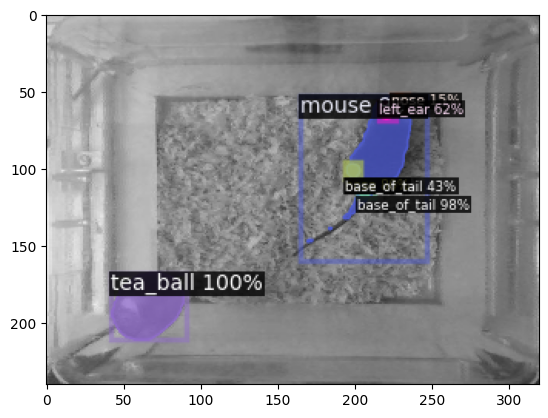

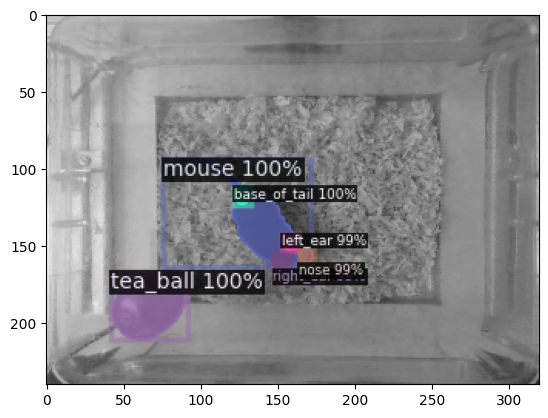

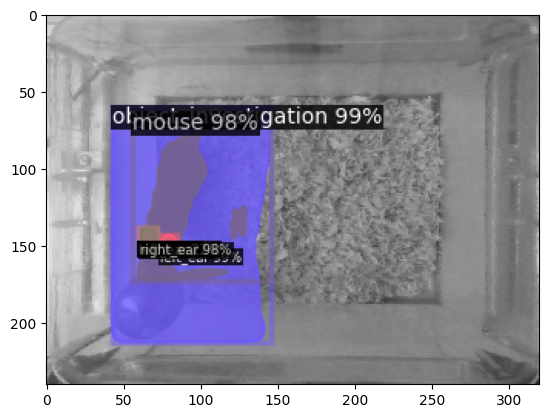

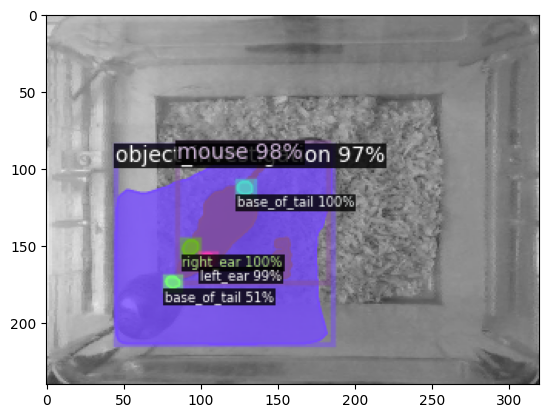

In [23]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_detection_dataset_dicts([f"{DATASET_NAME}_valid"])
for d in random.sample(dataset_dicts, 4):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=_dataset_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.SEGMENTATION   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    if IN_COLAB:
        cv2_imshow(out.get_image()[:, :, ::-1])
    else:
        plt.imshow(out.get_image()[:, :, ::-1])
        plt.show()
        

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~50. Not bad!

In [24]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
if IN_COLAB:
    evaluator = COCOEvaluator(f"{DATASET_NAME}_valid", cfg, False, output_dir="/content/eval_output/")
else:
    evaluator = COCOEvaluator(f"{DATASET_NAME}_valid", cfg, False, output_dir="eval_output/")

val_loader = build_detection_test_loader(cfg, f"{DATASET_NAME}_valid")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

WARNING [01/06 15:23:01 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[01/06 15:23:01 d2.data.datasets.coco]: Loaded 7 images in COCO format from sample_video_coco_dataset/valid/annotations.json
[01/06 15:23:01 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/06 15:23:01 d2.data.common]: Serializing 7 elements to byte tensors and concatenating them all ...
[01/06 15:23:01 d2.data.common]: Serialized dataset takes 0.02 MiB
[01/06 15:23:01 d2.evaluation.evaluator]: Start inference on 7 batches
[01/06 15:23:01 d2.evaluation.evaluator]: Total inference time: 0:00:00.145869 (0.072934 s / iter per device, on 1 devices)
[01/06 15:23:01 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.053102 s / iter per device, on 1 devices)
[01/06 15:23:01 d2.evaluation.c

# Upload or Download a video and test it based on your trained model

##Download a video from a URL

In [25]:
#e.g.
#!wget https://hosting-website.com/your-video.mp4

### Please change the VIDEO_INPUT to the path of your inference video

In [26]:
VIDEO_INPUT="/content/video60.mkv" #@param {type: "string"}
OUTPUT_DIR = "/content/eval_output"

In [27]:
VIDEO_INPUT = '../../sample_video/sample_video.mp4'
OUTPUT_DIR = "../../sample_video/"

In [28]:
import cv2
video = cv2.VideoCapture(VIDEO_INPUT)
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_per_second = video.get(cv2.CAP_PROP_FPS)
num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
basename = os.path.basename(VIDEO_INPUT)

In [29]:
import os 
os.makedirs(OUTPUT_DIR,exist_ok=True)

In [30]:
def _frame_from_video(video):
  attempt = 0
  for i in range(num_frames):
      success, frame = video.read()
      if success:
          yield frame
      else:
          attempt += 1
          if attempt >= 2000:
              break
          else:
              video.set(cv2.CAP_PROP_POS_FRAMES, i+1)
              print('Cannot read this frame:', i)
              continue

In [31]:
import pandas as pd
import pycocotools.mask as mask_util

In [32]:
class_names = _dataset_metadata.thing_classes
print(class_names)

['_background_', 'mouse', 'body', 'body_centroid', 'left_ear', 'right_ear', 'nose', 'head', 'wall', 'corner', 'base_of_tail', 'grooming', 'rearing', 'object_investigation', 'tea_ball', 'hand']


Frame number 0: {'frame_number': 0, 'x1': 160.23683166503906, 'y1': 190.2261199951172, 'x2': 336.2402648925781, 'y2': 344.6754150390625, 'instance_name': 'mouse', 'class_score': 0.9991045594215393, 'segmentation': {'size': [480, 640], 'counts': '\\c\\21iZ20VTN1O00O10j>4RA0O10O10000O100000001N10000000PU5OQkJ1O0O2O0000001O002N1O1O1O0001O1O1O001O010O11O01OO1O010O1O100O1O01O2O10O000O02O00O2O0O1O01000_BIY<n1A1O0000O11O3M1N10O1000O103L2O0O01001O001OO01O1O005K3M1O001O1O1O3M2N100O1O1O2O0O10O10O0100O01O010004K5L1N1O100O2N;E2N001O1O1O7I2N1O1O1O2N4L2N1O1O1N3N3M8H2N2M2O2M7FPPa4'}}
Frame number 0: {'frame_number': 0, 'x1': 280.5991516113281, 'y1': 324.3965148925781, 'x2': 301.3257141113281, 'y2': 344.28997802734375, 'instance_name': 'right_ear', 'class_score': 0.9980741739273071, 'segmentation': {'size': [480, 640], 'counts': '[QT44k>3L4N1N2N2O1N10001O000001O1N101N3N1M5Kdbn4'}}
Frame number 0: {'frame_number': 0, 'x1': 245.53170776367188, 'y1': 228.6380157470703, 'x2': 268.7048034667969, 'y2': 248.

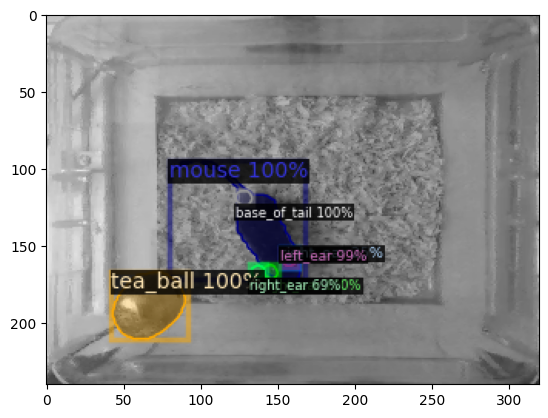

Processing frame number 1
Processing frame number 2
Processing frame number 3
Processing frame number 4
Processing frame number 5
Processing frame number 6
Processing frame number 7
Processing frame number 8
Processing frame number 9
Processing frame number 10
Processing frame number 11
Processing frame number 12
Processing frame number 13
Processing frame number 14
Processing frame number 15
Processing frame number 16
Processing frame number 17
Processing frame number 18
Processing frame number 19
Processing frame number 20
Processing frame number 21
Processing frame number 22
Processing frame number 23
Processing frame number 24
Processing frame number 25
Processing frame number 26
Processing frame number 27
Processing frame number 28
Processing frame number 29
Processing frame number 30
Processing frame number 31
Processing frame number 32
Processing frame number 33
Processing frame number 34
Processing frame number 35
Processing frame number 36
Processing frame number 37
Processing

Processing frame number 298
Processing frame number 299
Processing frame number 300
Processing frame number 301
Processing frame number 302
Processing frame number 303
Processing frame number 304
Processing frame number 305
Processing frame number 306
Processing frame number 307
Processing frame number 308
Processing frame number 309
Processing frame number 310
Processing frame number 311
Processing frame number 312
Processing frame number 313
Processing frame number 314
Processing frame number 315
Processing frame number 316
Processing frame number 317
Processing frame number 318
Processing frame number 319
Processing frame number 320
Processing frame number 321
Processing frame number 322
Processing frame number 323
Processing frame number 324
Processing frame number 325
Processing frame number 326
Processing frame number 327
Processing frame number 328
Processing frame number 329
Processing frame number 330
Processing frame number 331
Processing frame number 332
Processing frame num

Processing frame number 592
Processing frame number 593
Processing frame number 594
Processing frame number 595
Processing frame number 596
Processing frame number 597
Processing frame number 598
Processing frame number 599
Processing frame number 600
Processing frame number 601
Processing frame number 602
Processing frame number 603
Processing frame number 604
Processing frame number 605
Processing frame number 606
Processing frame number 607
Processing frame number 608
Processing frame number 609
Processing frame number 610
Processing frame number 611
Processing frame number 612
Processing frame number 613
Processing frame number 614
Processing frame number 615
Processing frame number 616
Processing frame number 617
Processing frame number 618
Processing frame number 619
Processing frame number 620
Processing frame number 621
Processing frame number 622
Processing frame number 623
Processing frame number 624
Processing frame number 625
Processing frame number 626
Processing frame num

Processing frame number 887
Processing frame number 888
Processing frame number 889
Processing frame number 890
Processing frame number 891
Processing frame number 892
Processing frame number 893
Processing frame number 894
Processing frame number 895
Processing frame number 896
Processing frame number 897
Processing frame number 898
Processing frame number 899
Processing frame number 900
Processing frame number 901
Processing frame number 902
Processing frame number 903
Processing frame number 904
Processing frame number 905
Processing frame number 906
Processing frame number 907
Processing frame number 908
Processing frame number 909
Processing frame number 910
Processing frame number 911
Processing frame number 912
Processing frame number 913
Processing frame number 914
Processing frame number 915
Processing frame number 916
Processing frame number 917
Processing frame number 918
Processing frame number 919
Processing frame number 920
Processing frame number 921
Processing frame num

Processing frame number 1073
Processing frame number 1074
Processing frame number 1075
Processing frame number 1076
Processing frame number 1077
Processing frame number 1078
Processing frame number 1079
Processing frame number 1080
Processing frame number 1081
Processing frame number 1082
Processing frame number 1083
Processing frame number 1084
Processing frame number 1085
Processing frame number 1086
Processing frame number 1087
Processing frame number 1088
Processing frame number 1089
Processing frame number 1090
Processing frame number 1091
Processing frame number 1092
Processing frame number 1093
Processing frame number 1094
Processing frame number 1095
Processing frame number 1096
Processing frame number 1097
Processing frame number 1098
Processing frame number 1099
Processing frame number 1100
Processing frame number 1101
Processing frame number 1102
Processing frame number 1103
Processing frame number 1104
Processing frame number 1105
Processing frame number 1106
Processing fra

In [33]:
frame_number = 0
tracking_results = []
VIS = True
for frame in _frame_from_video(video): 
    im = frame
    outputs = predictor(im)
    out_dict = {}  
    instances = outputs["instances"].to("cpu")
    num_instance = len(instances)
    if num_instance == 0:
        out_dict['frame_number'] = frame_number
        out_dict['x1'] = None
        out_dict['y1'] = None
        out_dict['x2'] = None
        out_dict['y2'] = None
        out_dict['instance_name'] = None
        out_dict['class_score'] = None
        out_dict['segmentation'] = None
        tracking_results.append(out_dict)
        out_dict = {}
    else:
        boxes = instances.pred_boxes.tensor.numpy()
        boxes = boxes.tolist()
        scores = instances.scores.tolist()
        classes = instances.pred_classes.tolist()

        has_mask = instances.has("pred_masks")

        if has_mask:
            rles =[
                   mask_util.encode(np.array(mask[:,:,None], order="F", dtype="uint8"))[0]
                   for mask in instances.pred_masks
            ]
            for rle in rles:
              rle["counts"] = rle["counts"].decode("utf-8")

        assert len(rles) == len(boxes)
        for k in range(num_instance):
            box = boxes[k]
            out_dict['frame_number'] = frame_number
            out_dict['x1'] = box[0]
            out_dict['y1'] = box[1]
            out_dict['x2'] = box[2]
            out_dict['y2'] = box[3]
            out_dict['instance_name'] = class_names[classes[k]]
            out_dict['class_score'] = scores[k]
            out_dict['segmentation'] = rles[k]
            if frame_number % 1000 == 0:
              print(f"Frame number {frame_number}: {out_dict}")
            tracking_results.append(out_dict)
            out_dict = {}
        
    # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    if VIS:
        v = Visualizer(im[:, :, ::-1],
                    metadata=_dataset_metadata, 
                    scale=0.5, 
                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
         )
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        out_image = out.get_image()[:, :, ::-1]
        if frame_number % 1000 == 0:
            if IN_COLAB:
                cv2_imshow(out_image)
            else:
                plt.imshow(out_image)
                plt.show()
            #Trun off the visulization to save time after the first frame
            VIS = False
    frame_number += 1
    print(f"Processing frame number {frame_number}")

video.release()

## All the tracking results will be saved to this Pandas dataframe. 



In [34]:
df = pd.DataFrame(tracking_results)

In [35]:
df.head()

frame_number          x1          y1          x2          y2 instance_name  \
0             0  160.236832  190.226120  336.240265  344.675415         mouse   
1             0  280.599152  324.396515  301.325714  344.289978     right_ear   
2             0  245.531708  228.638016  268.704803  248.297653  base_of_tail   
3             0   84.982445  334.311890  184.091339  422.386078      tea_ball   
4             0  304.228790  303.875916  325.790985  327.376251      left_ear   

   class_score                                       segmentation  
0     0.999105  {'size': [480, 640], 'counts': '\c\21iZ20VTN1O...  
1     0.998074  {'size': [480, 640], 'counts': '[QT44k>3L4N1N2...  
2     0.997335  {'size': [480, 640], 'counts': '[ac36h>4M2N2N2...  
3     0.997186  {'size': [480, 640], 'counts': 'PfX19e>3J9H8K2...  
4     0.993926  {'size': [480, 640], 'counts': 'iX_47f>5M2N2N2...

## Calculate the bbox center point x, y locations

In [36]:
cx = (df.x1 + df.x2)/2
cy = (df.y1 + df.y2)/2
df['cx'] = cx
df['cy'] = cy

In [37]:
df.tail()

frame_number          x1          y1          x2          y2  \
9471          1308  476.781067  267.009552  496.607971  287.521942   
9472          1308  448.401031  264.451752  470.506897  286.520477   
9473          1308  331.444153  159.872589  351.947906  181.922379   
9474          1308  477.287292  265.866608  496.088928  286.238922   
9475          1308  448.835938  264.672974  469.872192  285.756531   

     instance_name  class_score  \
9471     right_ear     0.915382   
9472     right_ear     0.911248   
9473     right_ear     0.737006   
9474      left_ear     0.438606   
9475      left_ear     0.197807   

                                           segmentation          cx  \
9471  {'size': [480, 640], 'counts': 'cko63j>6L3L3O1...  486.694519   
9472  {'size': [480, 640], 'counts': 'bgb64j>4L4M2N2...  459.453964   
9473  {'size': [480, 640], 'counts': 'Yik46g>5M2M3N1...  341.696030   
9474  {'size': [480, 640], 'counts': 'dko61k>8K3M2N2...  486.688110   
9475  {'size': [480, 640], 'counts': '`Vc68f>3N3M1O2...  459.354065   

              cy  
9471  277.265747  
9472  275.486115  
9473  170.897484  
9474  276.052765  
9475  275.214752

## Only save the top 1 prediction for each frame for each class
Note: You can change the number to save top n predictions for each frame and an instance name. head(2), head(5), or head(n)
To save all the predictions, please use `df.to_csv('my_tracking_results.csv')`.

In [38]:
df_top = df.groupby(['frame_number','instance_name'],sort=False).head(1)

In [39]:
df_top.head()

frame_number          x1          y1          x2          y2 instance_name  \
0             0  160.236832  190.226120  336.240265  344.675415         mouse   
1             0  280.599152  324.396515  301.325714  344.289978     right_ear   
2             0  245.531708  228.638016  268.704803  248.297653  base_of_tail   
3             0   84.982445  334.311890  184.091339  422.386078      tea_ball   
4             0  304.228790  303.875916  325.790985  327.376251      left_ear   

   class_score                                       segmentation          cx  \
0     0.999105  {'size': [480, 640], 'counts': '\c\21iZ20VTN1O...  248.238548   
1     0.998074  {'size': [480, 640], 'counts': '[QT44k>3L4N1N2...  290.962433   
2     0.997335  {'size': [480, 640], 'counts': '[ac36h>4M2N2N2...  257.118256   
3     0.997186  {'size': [480, 640], 'counts': 'PfX19e>3J9H8K2...  134.536892   
4     0.993926  {'size': [480, 640], 'counts': 'iX_47f>5M2N2N2...  315.009888   

           cy  
0  267.450768  
1  334.343246  
2  238.467834  
3  378.348984  
4  315.626083

## Visualize the center points with plotly scatter plot

In [40]:
df_vis = df_top[df_top.instance_name != 'Text'][['frame_number','cx','cy','instance_name']]

In [41]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

fig = px.scatter(df_vis, 
                 x="cx",
                 y="cy", 
                 color="instance_name",
                 hover_data=['frame_number','cx','cy'])
fig.show()

In [42]:
from pathlib import  Path
tracking_results_csv = f"{Path(dataset).stem}_{Path(VIDEO_INPUT).stem}_{cfg.SOLVER.MAX_ITER}_iters_mask_rcnn_tracking_results_with_segmenation.csv"
df_top.to_csv(tracking_results_csv)

## Download the tracking result CSV file to your local device

In [44]:
if IN_COLAB:
    from google.colab import files
    files.download(tracking_results_csv)

# The following sections are optional. 

## Caculate the distance of a pair of instances in a given frame

In [46]:
def paired_distance(frame_number,
                    this_instance='frog_m_2',
                    other_instance='frog_f_2'):
    df_dis = df_top[df_top["frame_number"]==frame_number][['cx','cy','instance_name']]
    df_this = df_dis[df_dis.instance_name == this_instance]
    df_other = df_dis[df_dis.instance_name == other_instance]
    try:
      dist = np.linalg.norm(df_this[['cx','cy']].values-df_other[['cx','cy']].values)
    except:
      dist = None


    return dist

## Calculate the distance of the instance from the current and previous frame

In [47]:
def instance_distance_between_frame(frame_number,
                                    instance_name='frog_m_1'):
    if frame_number < 1:
      return 0
    previous_frame_number = frame_number - 1
    df_dis = df_top[df_top["frame_number"]==frame_number][['cx','cy','instance_name']]
    df_dis_prev = df_top[df_top["frame_number"]==previous_frame_number][['cx','cy','instance_name']]
    df_dis = df_dis[df_dis.instance_name == instance_name]
    df_dis_prev = df_dis_prev[df_dis_prev.instance_name == instance_name]

    try:
      dist = np.linalg.norm(df_dis[['cx','cy']].values-df_dis_prev[['cx','cy']].values)
    except:
      dist = None
    
    return dist
    

In [48]:
df_top['dist_from_previous_frame_frog_m_1'] = df_top.frame_number.apply(instance_distance_between_frame)

/home/jeremy/anaconda3/envs/annolid-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## The total distance traveled for frog male in Tank 1 in pixels

In [51]:
df_top['dist_from_previous_frame_frog_m_1'].sum()


0.0

In [52]:

fig = px.line(x=df_top.frame_number, y=df_top.dist_from_previous_frame_frog_m_1, labels={'x':'frame_number', 'y':'distance from previous frame frog_m_1'})
fig.show()

## Distance between frog male in tank 2 and frog female in tank 2 in pixels

In [ ]:
df_top['dist_frog_m2_f2'] = df_top.frame_number.apply(paired_distance)

In [ ]:

fig = px.line(x=df_top.frame_number, y=df_top.dist_frog_m2_f2, labels={'x':'frame_number', 'y':'distance between frog male in tank 2 to frog female in tank 2'})
fig.show()

## Download and save the results to your local device

### Please change the desired CSV file name

In [ ]:
tracking_results_with_area_perimeter_csv = f"{tracking_results_csv.replace('.csv','_final.csv')}"
df_top.to_csv(tracking_results_with_area_perimeter_csv)
files.download(tracking_results_with_area_perimeter_csv)

## Save and download the trained model weights

In [ ]:
final_model_file = os.path.join(cfg.OUTPUT_DIR,'model_final.pth')
files.download(final_model_file)